In [36]:
# Collecting labels, annotation file: both labels and the image names are in string..

import pandas as pd
import os


path_trainSet = f"/Users/necatiisik/lfw_dataset/pairsDevTrain.txt"
path_testSet = f"/Users/necatiisik/lfw_dataset/pairsDevTest.txt"

f = open(path_testSet, "r")

# This assumes your spacing is arbitrary 
data = [line.split() for line in f]

my_list = []

for line in data:
    for item in line:

        try:
            if type(int(item)) is int:
                myString = temp + '_' + str(item.zfill(4)) + '.jpg'
                my_list.append((myString, temp))
        except ValueError:
            temp = item


csv_file = pd.DataFrame(my_list)
csv_file.to_csv("test_data.txt", header=None, index=None)


In [ ]:
# Converting label to integer

import pandas as pd

label_map = pd.read_csv("label_map.txt", header=None)
train_data = pd.read_csv("train_data.txt", header=None)
test_data = pd.read_csv("test_data.txt", header=None)


my_list = []

for i in range(len(train_data)):

    result_row = label_map.isin([train_data.iloc[i,1]])
    result_col = result_row.any()

    colName = result_col[result_col == True].index
    rowName = result_row[colName[0]][result_row[colName[0]] == True].index

    my_list.append((train_data.iloc[i,0], int(label_map.iloc[rowName,1])))

csv_file = pd.DataFrame(my_list)
csv_file.to_csv("train_fixed.txt", header=None, index=None)

In [28]:
# Forming label map --> 'str' to 'int' mapping of the labels..

import pandas as pd
import os


path_trainSet = f"/Users/necatiisik/lfw_dataset/pairsDevTrain.txt"
path_testSet = f"/Users/necatiisik/lfw_dataset/pairsDevTest.txt"

dataset_path = f"/Users/necatiisik/lfw_dataset/lfw"

f = open(path_testSet, "r")

counter = 0
label_list = []
for root, dirs, files in os.walk(dataset_path, topdown=False):
   for name in sorted(dirs):
      label_list.append((name, counter))
      counter += 1

csv_file = pd.DataFrame(label_list)
csv_file.to_csv("label_map.txt", header=None, index=None)




In [1]:
import os
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        slicer = slice(-9)
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0][slicer], self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(image)
        return image, label

path_trainSet = f"/Users/necatiisik/lfw_dataset/pairsDevTrain.txt"
path_testSet = f"/Users/necatiisik/lfw_dataset/pairsDevTest.txt"

datasetPath = f"/Users/necatiisik/lfw_dataset/lfw/"
trainLabelPath = f"/Users/necatiisik/lfw_dataset/train_fixed.csv"
testLabelPath = f"/Users/necatiisik/lfw_dataset/test_fixed.csv"


tf=transforms.Compose([
    transforms.ToTensor()
])

train_data = CustomImageDataset(trainLabelPath, datasetPath, transform=tf, target_transform=None)
test_data = CustomImageDataset(testLabelPath, datasetPath, transform=tf, target_transform=None)

batch_size = 64

train_loader = DataLoader(dataset = train_data,
                          batch_size = batch_size, 
                          shuffle = True)

test_loader = DataLoader(dataset = test_data,
                         batch_size = batch_size, 
                         shuffle = True)




In [106]:
class CNN(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()  #Dropout
        self.fc1 = nn.Linear(320, 64)
        self.fc2 = nn.Linear(64, 10)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))        
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = self.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


# Create an instance 
net = CNN().to(device)

print(net)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
)


In [107]:
#@title Define the loss function and the optimizer 
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=1.e-3)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    output = net(images)
    loss = loss_fun(output, labels)
    loss.backward()
    optimizer.step()
    
    if (i+1) % batch_size == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

In [112]:
num_epochs = 5
for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    print(type(images))
    print(labels)

    optimizer.zero_grad()
    output = net(images)



<class 'torch.Tensor'>
tensor([4336, 2567, 3754, 2690, 3574, 2065, 2498, 1453, 3573,    0, 3126, 4227,
        1456, 2401, 1499, 4601, 4898, 4449, 4671, 5271, 5626, 3517, 1568, 3164,
        4656, 2768, 1333, 5523, 3900,  618, 5655, 2014, 5687, 3495, 3578, 4993,
        2738, 1284, 2465, 1029, 3359, 2131, 1485, 3454, 1072, 3278, 1228, 4454,
         157,   95, 4298, 2485, 3968,   36, 2412, 1864, 2438, 3232, 3718, 2487,
         720, 3075, 2180, 3187])


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [ ]:
correct = 0
total = 0
for images,labels in test_loader:
  images = images.to(device)
  labels = labels.to(device)
  
  out = net(images)
  _, predicted_labels = torch.max(out,1)
  correct += (predicted_labels == labels).sum()
  total += labels.size(0)

print('Percent correct: %.3f %%' %((100*correct)/(total+1)))

Feature batch shape: torch.Size([64, 3, 250, 250])
Labels batch shape: torch.Size([64])


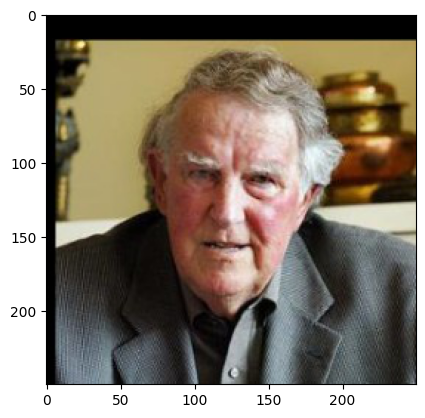

Label: 1481


In [105]:
import torch
import numpy as np
import matplotlib.pyplot as plt

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.movedim(0, -1)
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")



In [10]:
import pandas as pd

annotation_file = f"/Users/necatiisik/Downloads/lfw_dataList/peopleDevTrain.txt"
img_dir = f"/Users/necatiisik/lfw_dataset/lfw/"

idx = 800
img_labels = pd.read_csv(annotation_file, delimiter='\t')
img_path = os.path.join(img_dir, img_labels.iloc[idx, 0], img_labels.iloc[idx, 0] + '.jpg')

print(img_path)
print(type(img_path))

/Users/necatiisik/lfw_dataset/lfw/Dan_Quayle/Dan_Quayle.jpg
<class 'str'>
